In [1]:
!nvidia-smi

Wed Jul 13 00:35:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/hoanshiro/Smartphone-ABSA

fatal: destination path 'Smartphone-ABSA' already exists and is not an empty directory.


In [3]:
%cd /content/Smartphone-ABSA

/content/Smartphone-ABSA


In [4]:
!pip install -q -r requirements.txt

In [5]:
!pwd

/content/Smartphone-ABSA


## 1. Import Packages

In [6]:
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tqdm
from collections import defaultdict

import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report

### 1.1 User Define

In [7]:
import torch

class AbsaConfig():
    def __init__(self):
        self.rdrsegmenter_path = 'VnCoreNLP/VnCoreNLP-1.1.1.jar'
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        # Hyperparameters
        self.mode_path = 'vinai/phobert-base'
        self.MAX_LEN = 128
        self.TRAIN_BATCH_SIZE = 32
        self.VALID_BATCH_SIZE = 32
        self.TEST_BATCH_SIZE = 32
        self.EPOCHS = 10
        self.LEARNING_RATE = 1e-05
        self.THRESHOLD = 0.5  # threshold for the sigmoid



In [8]:
import re
import torch
import numpy as np
import pandas as pd
from transformers import AdamW
from vncorenlp import VnCoreNLP
from emoji import replace_emoji
# from conf import AbsaConfig
from tqdm import tqdm
import seaborn as sns
import tqdm.notebook as tq
import torch.nn as nn
import matplotlib.pyplot as plt

conf = AbsaConfig()


def display_all_dataframe():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.expand_frame_repr', False)
    pd.set_option('max_colwidth', -1)


def GetNewLabels():
    aspects = ['SCREEN', 'CAMERA', 'FEATURES', 'BATTERY', 'PERFORMANCE', 'STORAGE', 'DESIGN', 'PRICE', 'GENERAL',
               'SER&ACC']
    polarities = ['Positive', 'Neutral', 'Negative']
    new_labels = [f"{aspect}#{polarity}" for aspect in aspects for polarity in polarities]
    return new_labels


def GetStopWords():
    df_stopwords = pd.read_csv(
        'https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords-dash.txt',
        sep='\n', header=None, names=['stopwords'])
    stop_words = set(df_stopwords.stopwords.values)
    return stop_words


def labels2onehot(row, raw_label='label'):
    list_labels = row[raw_label].split(';')[:-1]
    list_processed_labels = [re.sub('[{}]', '', label) for label in list_labels]
    for label in list_processed_labels:
        row[label] = 1
    return row


def DisplayTokenLen(df, tokenizer):
    token_lens = []
    for txt in tqdm(df.tokenize):
        tokens = tokenizer.encode(txt, max_length=128)
        token_lens.append(len(tokens))

    sns.distplot(token_lens)


def PlotTrainingHistory(history):
    plt.rcParams["figure.figsize"] = (10, 7)
    plt.plot(history['train_acc'], label='train accuracy')
    plt.plot(history['val_acc'], label='validation accuracy')
    plt.title('Training history')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 1])
    plt.grid()


class TextProcessing:
    def __init__(self):
        self.rdrsegmenter = VnCoreNLP(conf.rdrsegmenter_path, annotators="wseg", max_heap_size='-Xmx500m')

    def ViTokenize(self, text, remove_stopwords=True):
        list_tokens = self.rdrsegmenter.tokenize(text)
        if remove_stopwords:
            stop_words = GetStopWords()
            list_tokens = [text for text in list_tokens[0] if text not in stop_words]
        else:
            list_tokens = list_tokens[0]
        tokenized_text = ' '.join(list_tokens)
        return tokenized_text

    def clean_text(self, text, remove_stopwords=True):
        # Lower
        text = text.lower()
        # Remove all emoji
        text = replace_emoji(text, replace='')
        # Remove all special char
        special_chars = r"[\"#$%&'()*+,.\-\/\\:;<=>@[\]^_`{|}~\n\r\t]"
        text = re.sub(special_chars, " ", text)
        # Vietnamese tokenize
        text = self.ViTokenize(text, remove_stopwords)
        return text


class SupportModel:
    def __init__(self):
        self.device = conf.device

    def loss_fn(self, outputs, targets):
        return torch.nn.BCEWithLogitsLoss()(outputs, targets)

    def train_model(self, training_loader, model, optimizer):
        losses = []
        correct_predictions = 0
        num_samples = 0
        # set model to training mode (activate droput, batch norm)
        model.train()
        # initialize the progress bar
        loop = tq.tqdm(enumerate(training_loader), total=len(training_loader),
                       leave=True, colour='steelblue')
        for batch_idx, data in loop:
            ids = data['input_ids'].to(self.device, dtype=torch.long)
            mask = data['attention_mask'].to(self.device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(self.device, dtype=torch.long)
            targets = data['targets'].to(self.device, dtype=torch.float)

            # forward
            outputs = model(ids, mask, token_type_ids)  # (batch,predict)=(32,8)
            loss = self.loss_fn(outputs, targets)
            losses.append(loss.item())
            # training accuracy, apply sigmoid, round (apply thresh 0.5)
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs == targets)
            num_samples += targets.size  # total number of elements in the 2D array

            # backward
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            # grad descent step
            optimizer.step()

            # Update progress bar
            # loop.set_description(f"")
            # loop.set_postfix(batch_loss=loss)

        # returning: trained model, model accuracy, mean loss
        return model, float(correct_predictions) / num_samples, np.mean(losses)

    def eval_model(self, validation_loader, model):
        losses = []
        correct_predictions = 0
        num_samples = 0
        # set model to eval mode (turn off dropout, fix batch norm)
        model.eval()

        with torch.no_grad():
            for batch_idx, data in enumerate(validation_loader, 0):
                ids = data['input_ids'].to(self.device, dtype=torch.long)
                mask = data['attention_mask'].to(self.device, dtype=torch.long)
                token_type_ids = data['token_type_ids'].to(self.device, dtype=torch.long)
                targets = data['targets'].to(self.device, dtype=torch.float)
                outputs = model(ids, mask, token_type_ids)

                loss = self.loss_fn(outputs, targets)
                losses.append(loss.item())

                # validation accuracy
                # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
                outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
                targets = targets.cpu().detach().numpy()
                correct_predictions += np.sum(outputs == targets)
                num_samples += targets.size  # total number of elements in the 2D array

        return float(correct_predictions) / num_samples, np.mean(losses)

    def get_predictions(self, model, data_loader):
        """
        Outputs:
          predictions -
        """
        model = model.eval()

        comments = []
        predictions = []
        prediction_probs = []
        target_values = []

        with torch.no_grad():
            for data in data_loader:
                comment = data["comment"]
                ids = data["input_ids"].to(self.device, dtype=torch.long)
                mask = data["attention_mask"].to(self.device, dtype=torch.long)
                token_type_ids = data['token_type_ids'].to(self.device, dtype=torch.long)
                targets = data["targets"].to(self.device, dtype=torch.float)

                outputs = model(ids, mask, token_type_ids)
                # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
                outputs = torch.sigmoid(outputs).detach().cpu()
                # thresholding at 0.5
                preds = outputs.round()
                targets = targets.detach().cpu()

                comments.extend(comment)
                predictions.extend(preds)
                prediction_probs.extend(outputs)
                target_values.extend(targets)

        predictions = torch.stack(predictions)
        prediction_probs = torch.stack(prediction_probs)
        target_values = torch.stack(target_values)

        return comments, predictions, prediction_probs, target_values

    def predict_raw_text(self, model, tokenizer, raw_text):
        cleaned_text = TextProcessing.clean_text(raw_text, remove_stopwords=False)
        #
        encoded_text = tokenizer.encode_plus(
            cleaned_text, max_length=conf.MAX_LEN, add_special_tokens=True,
            return_token_type_ids=True, pad_to_max_length=True,
            return_attention_mask=True, return_tensors='pt',
        )
        #
        input_ids = encoded_text['input_ids'].to(self.device)
        attention_mask = encoded_text['attention_mask'].to(self.device)
        token_type_ids = encoded_text['token_type_ids'].to(self.device)
        output = model(input_ids, attention_mask, token_type_ids)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        output = torch.sigmoid(output).detach().cpu()
        # thresholding at 0.5
        output = output.flatten().round().numpy()

        # Correctly identified the topic of the paper: High energy physics
        print(f"Comment: {raw_text}")
        target_list = GetNewLabels()
        for idx, p in enumerate(output):
            if p == 1:
                print(f"Label: {target_list[idx]}")



In [9]:
import torch
from transformers import AutoTokenizer, AutoModel
# from conf import AbsaConfig
# from utils import GetNewLabels


conf = AbsaConfig()
tokenizer = AutoTokenizer.from_pretrained(conf.mode_path)


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.comment = list(df['tokenize'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.comment)

    def __getitem__(self, index):
        comment = str(self.comment[index])
        comment = " ".join(comment.split())
        inputs = self.tokenizer.encode_plus(
            comment,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'comment': comment
        }


class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = AutoModel.from_pretrained('vinai/phobert-base', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, len(GetNewLabels()))

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## 2. Prepare Data

In [10]:
# from tqdm import tqdm
# display_all_dataframe()

# os.system('git clone https://github.com/vncorenlp/VnCoreNLP.git')
# os.system('wget -q https://github.com/LuongPhan/UIT-ViSFD/raw/main/UIT-ViSFD.zip -P data/')
# os.system('unzip data/UIT-ViSFD.zip -d data')

# TextProcessing = TextProcessing()

# ls_df = []
# new_labels = GetNewLabels()
# for data_name in tqdm(['Train', 'Dev', 'Test']):
#     df = pd.read_csv(f'data/{data_name}.csv')
#     df = df[['comment', 'label']]

#     for label in new_labels:
#         df[label] = 0

#     df = df.apply(lambda row: labels2onehot(row, raw_label='label'), axis=1) 

#     df['tokenize'] = df['comment'].apply(lambda text: TextProcessing.clean_text(text, remove_stopwords=False))
#     # df['stop_words_remove'] = df['comment'].apply(lambda text: clean_text(text, remove_stopwords=True))

#     df = df[['tokenize', *new_labels]]
#     ls_df.append(df)

# df_train, df_valid, df_test = ls_df

# df_train.to_csv('data/processed_train.csv', index=False)
# df_valid.to_csv('data/processed_valid.csv', index=False)
# df_test.to_csv('data/processed_test.csv', index=False)


### 2.1 Load Data

In [11]:
%cd /content/Smartphone-ABSA

/content/Smartphone-ABSA


In [12]:
df_train = pd.read_csv('data/processed_train.csv')
df_valid = pd.read_csv('data/processed_valid.csv')
df_test = pd.read_csv('data/processed_test.csv')

In [13]:
df_train.tail(5)

,tokenize,SCREEN#Positive,SCREEN#Neutral,SCREEN#Negative,CAMERA#Positive,CAMERA#Neutral,CAMERA#Negative,FEATURES#Positive,FEATURES#Neutral,FEATURES#Negative,...,DESIGN#Negative,PRICE#Positive,PRICE#Neutral,PRICE#Negative,GENERAL#Positive,GENERAL#Neutral,GENERAL#Negative,SER&ACC#Positive,SER&ACC#Neutral,SER&ACC#Negative
7781,8g cái đi đánh là mạng giật giật ko chịu nổi c...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7782,mua dk giảm 500k mà lỗi lòi ra hết treo màn_hì...,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
7783,máy sài 3 tháng rồi rất ok pin trâu khỏi nói s...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7784,rất tiếc hàng realme ko có ốp lưng ngoài nên k...,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
7785,mình rất thất_vọng khi mua máy này bắt wifi cự...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1


### 2.2 Select Max Length

In [14]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


100%|██████████| 7786/7786 [00:03<00:00, 1995.64it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


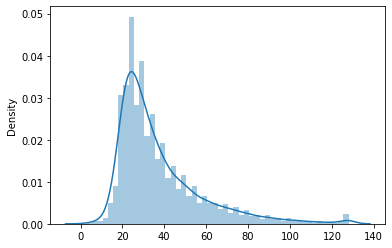

In [15]:
DisplayTokenLen(df_train, tokenizer)

### 2.3. Check Data

In [16]:
# Test the tokenizer
test_text = "máy sài 3 tháng rồi rất ok pin trâu khỏi nói sài cả ngày đến tối 12 giờ đêm mới sạc mình chơi game liên_quân cả ngày rất ok"
# generate encodings
encodings = tokenizer.encode_plus(test_text, 
                                  add_special_tokens = True,
                                  max_length = 128,
                                  truncation = True,
                                  padding = "max_length", 
                                  return_attention_mask = True, 
                                  return_tensors = "pt")
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html) 
encodings

{'input_ids': tensor([[    0,   558,  1302,  9412,   107,    78,   182,    59, 11685,  2179,
          2959,   353,    96,  1302,  9412,    94,    43,    30,   878,   445,
           232,   396,    60,  3941,    68,   379,  1724,  7660,    94,    43,
            59, 11685,     2,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,  

### 2.3 Transform for Pytorch Model

In [17]:
target_list = GetNewLabels()
MAX_LEN = conf.MAX_LEN
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)

In [18]:
# testing the dataset
next(iter(train_dataset))

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 'comment': 'mới mua máy này tại thegioididong thốt_nốt cảm_thấy ok bin trâu chụp ảnh đẹp loa nghe to bắt wf khoẻ sóng ổn_định giá_thành vừa với túi_tiền nhân_viên tư_vấn nhiệt_tình',
 'input_ids': tensor([    0,    60,   188,   558,    23,    35, 44553,  3385,  3385,  2662,
         33640,   841, 11685,  5967,  2959,   690,   284,   258,  3998,   523,
           889,   537,  2303,  3961,  3455,  1575,   726,  4097,   164,    15,
         11535,   650,  1408,  3857,     2,     1,     1,     1,     1,     1,
             1,     1,     1,

In [19]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=conf.TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=conf.VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=conf.TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

## 3. Model Setting

In [20]:
# from src.model import BERTClass

model = BERTClass()
# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False
model.to(conf.device)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (bert_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768

In [21]:
from transformers import AdamW
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)         

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


## 4. Training

In [22]:
# from src.utils import SupportModel

In [23]:
SupportModel = SupportModel()

In [24]:
# history = defaultdict(list)
# best_accuracy = 0
# EPOCHS = conf.EPOCHS
# for epoch in range(1, EPOCHS+1):
#     print(f'Epoch {epoch}/{EPOCHS}')
#     model, train_acc, train_loss = SupportModel.train_model(train_data_loader, model, optimizer)
#     val_acc, val_loss = SupportModel.eval_model(val_data_loader, model, optimizer)

#     print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

#     history['train_acc'].append(train_acc)
#     history['train_loss'].append(train_loss)
#     history['val_acc'].append(val_acc)
#     history['val_loss'].append(val_loss)
#     # save the best model
#     if val_acc > best_accuracy:
#         torch.save(model.state_dict(), os.path.join(data_dir,"output","MLTC_model_state.bin"))
#         best_accuracy = val_acc

In [25]:
# PlotTrainingHistory(history)

## 5. Evaluate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [26]:
# # Loading pretrained model (best model)
# model = BERTClass()
# model.load_state_dict(torch.load(os.path.join(data_dir,"output","MLTC_model_state.bin")))
# model = model.to(device)

In [27]:
# Evaluate the model using the test data
# test_acc, test_loss = eval_model(test_data_loader, model, optimizer)

In [28]:
# The accuracy looks OK, similar to the validation accuracy
# The model generalizes well !
# test_acc

In [29]:
# comments, predictions, prediction_probs, target_values = SupportModel.get_predictions(model, test_data_loader)

In [30]:
# print(f"comments:{len(comments)} \npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")

In [31]:
# # Generate Classification Metrics
# # note that the total support is greater than the number of samples
# # some samples have multiple lables

# print(classification_report(target_values, predictions, target_names=target_list))

## 6. Predict Raw Input

In [32]:
# SupportModel.predict_raw_text(model, tokenizer, raw_text='')

## 7. BigDL

## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).

In [33]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

openjdk version "1.8.0_312"
OpenJDK Runtime Environment (build 1.8.0_312-8u312-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.312-b07, mixed mode)


**Install Analytics Zoo**

 

[Conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/) is needed to prepare the Python environment for running this example. 

**Note**: The following code cell is specific for setting up conda environment on Colab; for general conda installation, please refer to the [install guide](https://docs.conda.io/projects/conda/en/latest/user-guide/install/) for more details.

In [34]:
import sys

# Set current python version
python_version = f"3.7.10"

In [ ]:
# Install Miniconda
# !wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
!chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
!./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local

# Update Conda
!conda install --channel defaults conda python=$python_version --yes
!conda update --channel defaults --all --yes

# Append to the sys.path
_ = (sys.path
        .append(f"/usr/local/lib/python3.7/site-packages"))

os.environ['PYTHONHOME']="/usr/local"

You can install the latest pre-release version using `pip install --pre --upgrade analytics-zoo[ray]`.

In [ ]:
# Install latest pre-release version of Analytics Zoo 
# Installing Analytics Zoo from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade analytics-zoo[ray]

In [37]:
# Install latest pre-release version of BigDL Orca 
# Installing BigDL Orca from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade bigdl-orca
!pip install jep==3.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
# Install python dependencies
!pip install torch==1.7.1 torchvision==0.8.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Distributed PyTorch using Orca APIs**

In this guide we will describe how to scale out PyTorch programs using `torch_distributed` package on Orca in 4 simple steps.

In [39]:
# import necesary libraries and modules
from __future__ import print_function
import os
import argparse

from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext

### **Step 1: Init Orca Context**

In [43]:
# recommended to set it to True when running BigDL in Jupyter notebook. 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

cluster_mode = "local"

if cluster_mode == "local":
    init_orca_context(cores=1, memory="2g") # run in local mode
elif cluster_mode == "k8s":
    init_orca_context(cluster_mode="k8s", num_nodes=2, cores=4) # run on K8s cluster
elif cluster_mode == "yarn":
    init_orca_context(
        cluster_mode="yarn-client", cores=4, num_nodes=2, memory="2g",
        driver_memory="10g", driver_cores=1,
        conf={"spark.rpc.message.maxSize": "1024",
              "spark.task.maxFailures": "1",
              "spark.driver.extraJavaOptions": "-Dbigdl.failure.retryTimes=1"}) # run on Hadoop YARN cluster

Initializing orca context


This is the only place where you need to specify local or distributed mode. View [Orca Context](https://analytics-zoo.readthedocs.io/en/latest/doc/Orca/Overview/orca-context.html) for more details.

**Note**: You should export HADOOP_CONF_DIR=/path/to/hadoop/conf/dir when you run on Hadoop YARN cluster.

In [41]:
# from zoo.orca.learn.pytorch import Estimator
# from zoo.orca.learn.metrics import Accuracy

# est = Estimator.from_torch(model=model, optimizer=optimizer, loss=torch.nn.BCELoss(), metrics=[Accuracy()])

### Step 2: Training

In [ ]:
from bigdl.orca.learn.pytorch import Estimator
from bigdl.orca.learn.metrics import Accuracy

est = Estimator.from_torch(model=model,
                           optimizer=optimizer,
                           loss=torch.nn.BCEWithLogitsLoss(),
                           metrics=[Accuracy()])

creating: createTorchLoss
creating: createTorchOptim


In [ ]:
from bigdl.orca.learn.trigger import EveryEpoch 


est.fit(data=train_data_loader, epochs=1, validation_data=val_data_loader,
        checkpoint_trigger=EveryEpoch())

### Step 3: Evaluate

In [ ]:
result = est.evaluate(data=test_data_loader, batch_size=conf.TEST_BATCH_SIZE)
for r in result:
    print(r, ":", result[r])

The accuracy of this model has reached 98%.

In [ ]:
# stop orca context when program finishes
stop_orca_context()